In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
    %tensorflow_version 2.x  # Colab only.
except Exception:
    pass

import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

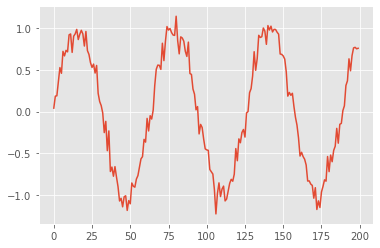

In [3]:
# make the original data
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1   # 0.1 is angular frequency

# plot it
plt.plot(series)
plt.show()

In [4]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10    # which means we going to use 10 previous timestamps to predict the next timestamps
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, D) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (190, 10, 1) Y.shape (190,)


In [5]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = SimpleRNN(5, activation='tanh')(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(loss='mse', 
              optimizer=Adam(lr=0.1))

# train the RNN
r = model.fit(X[:-N//2], Y[:-N//2], 
              epochs=80, 
              validation_data=(X[-N//2:], Y[-N//2:]))

Epoch 1/80
3/3 [==============================] - 0s 92ms/step - loss: 0.5533 - val_loss: 0.0744
Epoch 2/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0924 - val_loss: 0.1037
Epoch 3/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0772 - val_loss: 0.0440
Epoch 4/80
3/3 [==============================] - 0s 10ms/step - loss: 0.0552 - val_loss: 0.0526
Epoch 5/80
3/3 [==============================] - 0s 10ms/step - loss: 0.0484 - val_loss: 0.0382
Epoch 6/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0386 - val_loss: 0.0327
Epoch 7/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0341 - val_loss: 0.0272
Epoch 8/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0235 - val_loss: 0.0226
Epoch 9/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0261 - val_loss: 0.0210
Epoch 10/80
3/3 [==============================] - 0s 9ms/step - loss: 0.0232 - val_loss: 0.0267
Epoch 11/80
3/3 [===================

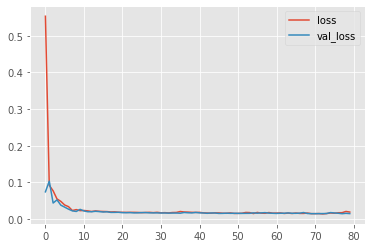

In [6]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

"Wrong" forecast using true targets

In [7]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

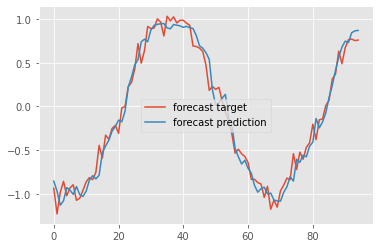

In [8]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

Forecast future values (use only self-predictions for making future predictions)

In [9]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1, 1))[0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

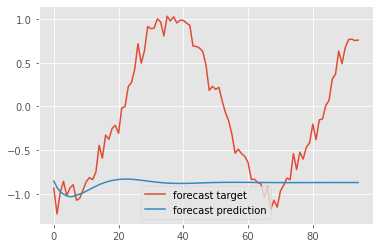

In [10]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()